In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

import matplotlib.pyplot as plt
import tikzplotlib
import pylab
from mpl_toolkits.mplot3d import Axes3D
import plotly.figure_factory as ff
from scipy.spatial import Delaunay

In [2]:
# Construct model
model = Sequential()
model.add(Dense(100, input_shape=[2,], activation='selu'))
model.add(Dense(100, activation='selu', activity_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(Dense(100, activation='selu', activity_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(Dense(100, activation='selu', activity_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(Dense(100, activation='selu', activity_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(Dense(100, activation='selu', activity_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(Flatten())
model.add(Dense(1))

In [3]:
def theta2cart(theta, r): # converts random thetas and fixed r into x and y coordinates
    x_out = tf.math.multiply(r, tf.math.cos(theta)) # x = 4cos(theta_in)
    y_out = tf.math.multiply(r, tf.math.sin(theta)) # y = 4sin(theta_in)
    
    pts = tf.transpose(tf.stack([x_out,y_out],0))
    return pts

In [4]:
def out_bnd_fn(theta_out): # f(4,theta) = 4sin(5theta)
    f_true = tf.transpose(tf.math.scalar_mul(4, tf.math.sin(tf.math.scalar_mul(5,theta_out))))
    return f_true

In [5]:
# Used as pre-training to train the network to satisfy the boundary condition
def bnd_loss_fn(f_pred_out, f_pred_in, theta_out, theta_in): # loss_fn(model, [x,y], [theta_in], [theta_out])
#     f_pred = tf.squeeze(f_pred)
#     print("f_pred shape" ,tf.shape(f_pred))

# Find loss for outer boundary points #####################################################################
    f_true_out =  out_bnd_fn(theta_out)
    f_true_in = tf.zeros(tf.shape(theta_in))

    loss_out = tf.keras.metrics.mean_squared_error(f_true_out, f_pred_out)# MSE outer bound points
    loss_in = tf.keras.metrics.mean_squared_error(f_true_in, f_pred_in)
    loss = loss_out + loss_in
    return loss

In [6]:
# Used as pre-training to train the network to satisfy the boundary condition
def out_bnd_train_for():

# Define training parameters ##############################################################################    
    optimizer = tf.keras.optimizers.Ftrl(learning_rate=0.1) # Fancy gradient decent
    epochs = 200
    train_loss_results = [] # For tracking loss during training
    iterations_per_epoch = 100

    theta_out_size = 1000 # Number of outer boundary points to sample each iteration

    for epoch in range(epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        
        for iteration in range(iterations_per_epoch):
    
# Sample outer bound thetas ###############################################################################
            theta_out = tf.random.uniform([1,theta_out_size], minval=0, maxval=2*np.pi)
            out_bnd_pts = theta2cart(theta_out,4)
            
# Optimize the network with respect to hyperparameters ####################################################
            
            with tf.GradientTape() as t:
                f_pred = model(out_bnd_pts, training=True)
                loss = out_bnd_loss_fn(f_pred, theta_out) # Loss
            grads = t.gradient(loss, model.trainable_weights) # Find model gradients
            optimizer.apply_gradients(zip(grads, model.trainable_weights)) # Perform gradient decent
            epoch_loss_avg.update_state(loss) # Track loss
            #optimizer.minimize(loss_fn(model, theta_out), model.trainable_weights)
            # End training iteration
        train_loss_results.append(epoch_loss_avg.result())
        
        if epoch % 10 == 0:
            print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
        # End Epoch

In [7]:
def loss_fn(model, int_pts, theta_in, theta_out): # loss_fn(model, [x,y], [theta_in], [theta_out])
    
# Find loss for interior points ###########################################################################
    with tf.GradientTape() as t:
        t.watch(int_pts)
        g = model(int_pts)
        #print('g = ', g)
    grad_g = t.gradient(g, int_pts) 
    #print(grad_g)
    #dg_dx = grad_g[0:,0,0] # dg/dx
    #print(dg_dx)
    #dg_dy = grad_g[0:,0,1] # dg/dy
    grad_g_l2_norm = tf.nn.l2_loss(grad_g)/1000 # Dirichlet energies / 2
    
    # Find loss for boundary conditions #########################################################################    
#         theta_out = tf.random.uniform([1,theta_out_size], minval=0, maxval=2*np.pi)
    out_bnd_pts = theta2cart(theta_out,4)

#         theta_in = tf.random.uniform([1,theta_in_size], minval=0, maxval=2*np.pi)
    in_bnd_pts = theta2cart(theta_in,2)            
    
    Lambda = 1000

    f_pred_out = model(out_bnd_pts, training=True)
    f_pred_in = model(in_bnd_pts, training=True)
    bnd_err = Lambda * bnd_loss_fn(f_pred_out, f_pred_in, theta_out, theta_in)
    
# # Find loss for inner boundary points #####################################################################
#     in_bnd_pts = theta2cart(theta_in, 2)
#     in_bnd_true = tf.zeros(tf.shape(theta_in))
#     in_bnd_pred = model(in_bnd_pts) # in_bnd_err = g(x,y)-0
#     #print("in_bnd_pred shape: ", tf.shape(in_bnd_pred))
#     in_bnd_mse = tf.keras.metrics.mean_squared_error(in_bnd_pred, in_bnd_true) # MSE inner bound points
#     print("size in_bnd_mse = ", tf.size(in_bnd_mse))
    
# # Find loss for outer boundary points #####################################################################    
#     out_bnd_pts = theta2cart(theta_out,4)
#     out_bnd_true = out_bnd_fn(theta_out)
#     out_bnd_pred = model(out_bnd_pts) # MSE outer bound points
#     #print("out_bnd_pred shape: ", tf.shape(out_bnd_pred))
#     out_bnd_mse = tf.keras.metrics.mean_squared_error(out_bnd_pts, out_bnd_pred)
#     print("size out_bnd_mse = ", tf.size(out_bnd_mse))

# # Find total weighted boundary error ######################################################################
#     bnd_err = in_bnd_mse + out_bnd_mse

#     weighted_bnd_loss = tf.math.scalar_mul(Lambda, bnd_err)

# Total loss ##############################################################################################
    loss = tf.math.add(grad_g_l2_norm, bnd_err)
    
    return loss

In [8]:
# Train network
def train_for():
    
# Train network on outer boundary first ###################################################################
#     print('Training bound...')
#     bnd_train_for()

# Define training parameters ##############################################################################    
    print('Training network on all conditions...')
    
    optimizer = tf.keras.optimizers.Ftrl() # Fancy gradient decent
    epochs = 20
    train_loss_results = [] # For tracking loss during training
    iterations_per_epoch = 100

    int_pts_size = 100 # Number of interior points to sample each iteration
    theta_in_size = 1000 # Number of inner boundary points to sample each iteration
    theta_out_size = 1000 # Number of outer boundary points to sample each iteration


    for epoch in range(epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        
        for iteration in range(iterations_per_epoch):
# Sample interior points ##################################################################################
            r_int = tf.math.sqrt( # r = sqrt(R2^2+ rand()*(R4^2-R2^2))
                tf.add(4, tf.math.scalar_mul(12, tf.random.uniform([1,int_pts_size], minval=0, maxval=1))))
            theta_int = tf.random.uniform([1,int_pts_size], minval=0, maxval=2*np.pi)

            int_pts = theta2cart(theta_int, r_int)
    
# Sample inner bound thetas ###############################################################################    
            theta_in = tf.random.uniform([1,theta_in_size], minval=0, maxval=2*np.pi)
    
# Sample outer bound thetas ###############################################################################
            theta_out = tf.random.uniform([1,theta_out_size], minval=0, maxval=2*np.pi)
            
# Optimize the network with respect to hyperparameters ####################################################
            
            with tf.GradientTape() as t:
                loss = loss_fn(model, int_pts, theta_in, theta_out) # Loss
            grads = t.gradient(loss, model.trainable_weights) # Find model gradients
            optimizer.apply_gradients(zip(grads, model.trainable_weights)) # Perform gradient decent
            epoch_loss_avg.update_state(loss) # Track loss
            # End training iteration
        train_loss_results.append(epoch_loss_avg.result())
        
        if epoch % 1 == 0:
            print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
        # End Epoch

In [9]:
# out_bnd_train_for()
train_for()

Training network on all conditions...
Epoch 000: Loss: 5272.454
Epoch 001: Loss: 2831.937
Epoch 002: Loss: 1831.953
Epoch 003: Loss: 1253.339
Epoch 004: Loss: 920.940
Epoch 005: Loss: 683.813
Epoch 006: Loss: 539.470
Epoch 007: Loss: 409.365
Epoch 008: Loss: 326.300
Epoch 009: Loss: 235.774
Epoch 010: Loss: 212.408
Epoch 011: Loss: 170.117
Epoch 012: Loss: 111.182
Epoch 013: Loss: 105.634
Epoch 014: Loss: 86.451
Epoch 015: Loss: 61.248
Epoch 016: Loss: 54.643
Epoch 017: Loss: 51.788
Epoch 018: Loss: 45.771
Epoch 019: Loss: 24.232


In [10]:
# Generate test points to plot ############################################################################
in_bnd_pts_size = 10000 # Number of inner boundary points to sample 
out_bnd_pts_size = 10000 # Number of outer boundary points to sample 
int_pts_size = 10000 # Number of interior points to sample

# Sample interior points ##################################################################################
r_int = tf.math.sqrt( # r = sqrt(R2^2+ rand()*(R4^2-R2^2))
    tf.add(4, tf.math.scalar_mul(12, tf.random.uniform([1, int_pts_size], minval = 0, maxval=1))))
theta_int = tf.random.uniform([1, int_pts_size], minval=0, maxval=2*np.pi)
# Convert to cartestian
int_pts = theta2cart(theta_int, r_int)

# Sample inner boundary points ############################################################################
theta_in = tf.random.uniform([1, in_bnd_pts_size], minval=0, maxval=2*np.pi)
in_bnd_pts = theta2cart(theta_in, 2)

# Sample outer boundary points ############################################################################
theta_out = tf.random.uniform([1, out_bnd_pts_size], minval=0, maxval=2*np.pi)
out_bnd_pts = theta2cart(theta_out, 4)
# print(out_bnd_pts.shape)
# print(out_bnd_pts)

test_pts = tf.concat([int_pts, in_bnd_pts, out_bnd_pts],0)
# print(test_pts)
print("test_pts_shape: ", test_pts.shape)

z = model(test_pts)
print("z shape: ", tf.shape(z))

test_pts_shape:  (30000, 1, 2)
z shape:  tf.Tensor([30000     1], shape=(2,), dtype=int32)


(30000,)
(30000,)
(30000,)


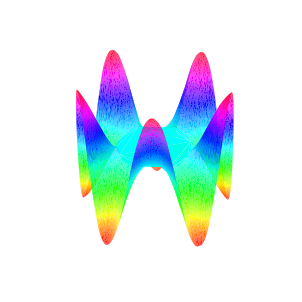

In [11]:
# Plot ####################################################################################################

fig = pylab.figure(figsize=plt.figaspect(1))
ax = Axes3D(fig)

xmin = -4
xmax = 4
ymin = -4
ymax = 4
zmin = -4
zmax = 4

X = test_pts[0:, 0, 0].numpy()
print(X.shape)
Y = test_pts[0:, 0, 1].numpy()
print(Y.shape)
Z = z[0:, 0].numpy()
print(Z.shape)

ax.plot_trisurf(X,Y,Z, cmap=plt.cm.hsv)
ax.view_init(30, 20)
ax.grid(b=None)
ax.axis('off')
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), zlim=(zmin,zmax))
plt.show()

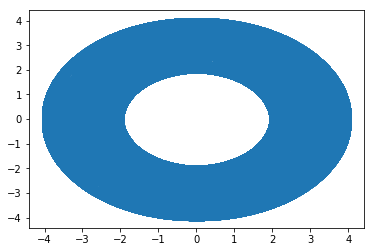

In [12]:
# Check sample points
plt.scatter(X,Y)
plt.show()

In [32]:
# Alternative Plotting ####################################################################################
u = np.linspace(0, 2*np.pi, 100)
# print(u.shape)
v = np.linspace(2, 4, 100)

u,v = np.meshgrid(u,v)
u = u.flatten()
# print(u.shape)
v = v.flatten()

x = v*np.cos(u)
y = v*np.sin(u)

U = tf.convert_to_tensor(u)
V = tf.convert_to_tensor(v)

sample_pts = theta2cart(U,V)

Z = model(sample_pts)
# print("Z_shape: ", test_pts.shape)

z = Z[0:,0].numpy()

points2D = np.vstack([u,v]).T
tri = Delaunay(points2D)
simplices = tri.simplices

fig = ff.create_trisurf(x=x, y=y, z=z, simplices=simplices,title="Laplace DVM", plot_edges=False, colormap="Portland")
fig.show()